In [1]:
import numpy as np
import pandas as pd
import re
import scipy.stats as stats

#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import RobustScaler

import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import json
import folium
import base64
import json

### 생필품 가격 - 유동인구수 상관분석을 위한 dataframe

In [63]:
# dataframe 행 생략없이 출력
pd.set_option('display.max_rows', 4000)

In [3]:
df_necessities = pd.read_csv('../datas/huge/df_necessities.csv', encoding='cp949')
df_necessities = df_necessities.drop(['Unnamed: 0'], axis=1)
df_market_add = pd.read_csv('../datas/huge/df_market_add.csv', encoding='cp949')
df_market_add = df_market_add.drop(['Unnamed: 0'], axis=1)
df_customer = pd.read_csv('../datas/huge/df_customer.csv', encoding='cp949')
df_customer = df_customer.drop(['Unnamed: 0'], axis=1)

In [4]:
# 생필품가격 데이터에 주소 데이터 병합
df1 = pd.merge(df_necessities, df_market_add, on=['시장이름'], how='left') 

In [5]:
df_check = df1[df1['위도'].isnull()]
df_check['시장이름'].unique()

array([], dtype=object)

In [6]:
# 유동인구수 데이터 추가로 병합 
df2 = pd.merge(df1, df_customer, on=['년도','분기','시장이름'], how='left') 

In [7]:
df2

,일련번호,시장이름,품목이름,실판매규격,가격(원),년도-월,자치구이름,년도,분기,위도,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
0,1621162,통인시장,양파(1.5kg망),1kg,2000,2020-12,종로구,2020,4,37.580818,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
1,1628949,남부종합시장,호박,1개268g,1500,2020-12,서초구,2020,4,37.494920,...,174.0,176.0,240.0,182.0,358.0,303.0,180.0,175.0,247.0,188.0
2,1622882,통인시장,양파(1.5kg망),1kg,2000,2020-12,종로구,2020,4,37.580818,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
3,1622883,통인시장,상추(100g),400g,3000,2020-12,종로구,2020,4,37.580818,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
4,1622885,통인시장,호박(인큐베이터),1개,1000,2020-12,종로구,2020,4,37.580818,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167863,449830,구로시장,달걀,10개,1500,2013-05,구로구,2013,2,37.488535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167864,449831,구로시장,"조기(냉동,수입산)",1마리(20cm),1500,2013-05,구로구,2013,2,37.488535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167865,449832,구로시장,"명태(러시아,냉동)",1마리(42cm),1700,2013-05,구로구,2013,2,37.488535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167866,449833,구로시장,"오징어(생물,국산)",1마리,2500,2013-05,구로구,2013,2,37.488535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# null 확인
# 확인결과 merge를 잘못한게 아니라 특정 년도(2013년), 분기에 유동인구 데이터가 없는 행들임
df2[df2['총_생활인구_수'].isnull()]

,일련번호,시장이름,품목이름,실판매규격,가격(원),년도-월,자치구이름,년도,분기,위도,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
189,1623370,장위골목시장,무,1개,1500,2020-12,성북구,2020,4,37.612047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,1623369,장위골목시장,배추(2.5~3kg),"1포기 (1망 3입 9,000원)",3000,2020-12,성북구,2020,4,37.612047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,1623368,장위골목시장,"배(신고, 600g)",1개,4000,2020-12,성북구,2020,4,37.612047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195,1625054,장위골목시장,"배(신고, 600g)",1개,5000,2020-12,성북구,2020,4,37.612047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,1625053,장위골목시장,"사과(부사, 300g)","1개 (5개 10,000원)",2000,2020-12,성북구,2020,4,37.612047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167863,449830,구로시장,달걀,10개,1500,2013-05,구로구,2013,2,37.488535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167864,449831,구로시장,"조기(냉동,수입산)",1마리(20cm),1500,2013-05,구로구,2013,2,37.488535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167865,449832,구로시장,"명태(러시아,냉동)",1마리(42cm),1700,2013-05,구로구,2013,2,37.488535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167866,449833,구로시장,"오징어(생물,국산)",1마리,2500,2013-05,구로구,2013,2,37.488535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# 결측값이 있는 행 전체 제거
df = df2[df2['총_생활인구_수'].notna()].reset_index().drop(['index'], axis = 1) 
df

,일련번호,시장이름,품목이름,실판매규격,가격(원),년도-월,자치구이름,년도,분기,위도,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
0,1621162,통인시장,양파(1.5kg망),1kg,2000,2020-12,종로구,2020,4,37.580818,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
1,1628949,남부종합시장,호박,1개268g,1500,2020-12,서초구,2020,4,37.494920,...,174.0,176.0,240.0,182.0,358.0,303.0,180.0,175.0,247.0,188.0
2,1622882,통인시장,양파(1.5kg망),1kg,2000,2020-12,종로구,2020,4,37.580818,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
3,1622883,통인시장,상추(100g),400g,3000,2020-12,종로구,2020,4,37.580818,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
4,1622885,통인시장,호박(인큐베이터),1개,1000,2020-12,종로구,2020,4,37.580818,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147814,749804,구로시장,달걀,10개,1500,2015-04,구로구,2015,2,37.488535,...,283.0,253.0,362.0,101.0,1.0,166.0,226.0,222.0,325.0,82.0
147815,749805,구로시장,"조기(냉동,수입산)",1마리(20cm),1500,2015-04,구로구,2015,2,37.488535,...,283.0,253.0,362.0,101.0,1.0,166.0,226.0,222.0,325.0,82.0
147816,749806,구로시장,"명태(러시아,냉동)",1마리(42cm),1700,2015-04,구로구,2015,2,37.488535,...,283.0,253.0,362.0,101.0,1.0,166.0,226.0,222.0,325.0,82.0
147817,749807,구로시장,"오징어(생물,국산)",1마리,2500,2015-04,구로구,2015,2,37.488535,...,283.0,253.0,362.0,101.0,1.0,166.0,226.0,222.0,325.0,82.0


In [10]:
# 결측치 없음 확인
df[df['총_생활인구_수'].isnull()]

,일련번호,시장이름,품목이름,실판매규격,가격(원),년도-월,자치구이름,년도,분기,위도,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수


In [11]:
# column 이름 확인
df.columns.values.tolist()

['일련번호',
 '시장이름',
 '품목이름',
 '실판매규격',
 '가격(원)',
 '년도-월',
 '자치구이름',
 '년도',
 '분기',
 '위도',
 '경도',
 '총_생활인구_수',
 '남성_생활인구_수',
 '여성_생활인구_수',
 '연령대_10_생활인구_수',
 '연령대_20_생활인구_수',
 '연령대_30_생활인구_수',
 '연령대_40_생활인구_수',
 '연령대_50_생활인구_수',
 '연령대_60_이상_생활인구_수',
 '시간대_1_생활인구_수',
 '시간대_2_생활인구_수',
 '시간대_3_생활인구_수',
 '시간대_4_생활인구_수',
 '시간대_5_생활인구_수',
 '시간대_6_생활인구_수',
 '월요일_생활인구_수',
 '화요일_생활인구_수',
 '수요일_생활인구_수',
 '목요일_생활인구_수',
 '금요일_생활인구_수',
 '토요일_생활인구_수',
 '일요일_생활인구_수',
 '남성연령대_10_월요일시간대_1_생활인구_수',
 '남성연령대_10_월요일시간대_2_생활인구_수',
 '남성연령대_10_월요일시간대_3_생활인구_수',
 '남성연령대_10_월요일시간대_4_생활인구_수',
 '남성연령대_10_월요일시간대_5_생활인구_수',
 '남성연령대_10_월요일시간대_6_생활인구_수',
 '남성연령대_10_화요일시간대_1_생활인구_수',
 '남성연령대_10_화요일시간대_2_생활인구_수',
 '남성연령대_10_화요일시간대_3_생활인구_수',
 '남성연령대_10_화요일시간대_4_생활인구_수',
 '남성연령대_10_화요일시간대_5_생활인구_수',
 '남성연령대_10_화요일시간대_6_생활인구_수',
 '남성연령대_10_수요일시간대_1_생활인구_수',
 '남성연령대_10_수요일시간대_2_생활인구_수',
 '남성연령대_10_수요일시간대_3_생활인구_수',
 '남성연령대_10_수요일시간대_4_생활인구_수',
 '남성연령대_10_수요일시간대_5_생활인구_수',
 '남성연령대_10_수요일시간대_6_생활인구_수',
 '남성연령대_10_목요일시간대_1_생활인구_

## 시각화 1번 : 품목별로 14년~20년 기간동안 전통시장에서 얼마나 많이 취급되었는지 

In [64]:
#품목의 빈도수 계산
freq = df[['시장이름','실판매규격','품목이름']].groupby(['품목이름','실판매규격']).count()
freq_s = freq.sort_values(by = ['시장이름'], ascending = False)
freq_s

,,시장이름
품목이름,실판매규격,
오이(다다기),1개,6660
달걀(30개),30개,5137
달걀(10개),10개,5104
돼지고기(생삼겹살),600g,4952
배추(2.5~3kg),1포기,4773
무(1kg),1개,4558
"사과(부사, 300g)",1개,4323
상추(100g),100g,4186
"배(신고, 600g)",1개,4042


In [13]:
# 시장별로 유동인구수 편차 확인
# df[['시장이름','총_생활인구_수']].drop_duplicates(['시장이름']).sort_values(by = ['총_생활인구_수'], ascending = False)

시장별로 유동인구수 차이가 크다해도 가격이 변함에 따라 유동인구수도 변한다면 상관계수값에는 영향이 없을지도?

특정시장 분기별(7 * 4 = 28row) 특정품목 가격 - 유동인구

함수로 자동화 - 
품목이름, 실판매규격만 넣으면 알아서 outlier 제거하고 시장별로 상관계수값뽑고 산점도, 지도시각화 -> 가격정책이 유의미한 시장 찾음   
품목이름으로 시작하는것만 추출 -> 실판매규격으로 시작하는것만 추출



### 공통함수 생성 시도..

시각화 2번 : 빈도수 상위 ~개 품목별로 상관계수가 유의미한 시장 찾기?

In [14]:
df_treat = df[['시장이름','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']=='쇠고기(한우,불고기)')&(df['실판매규격']=='600g')&(df['년도']!=2020)&(df['년도']!=2019)]  
df_gpp = df_treat.groupby(['시장이름','분기'])[['가격(원)']].mean().reset_index()
df_gpp

,시장이름,분기,가격(원)
0,경동시장,1,23000.000000
1,경동시장,2,24666.666667
2,경동시장,3,25333.333333
3,경동시장,4,25333.333333
4,고척근린시장,1,21440.000000
5,고척근린시장,2,22657.142857
6,고척근린시장,3,23360.000000
7,고척근린시장,4,24466.666667
8,공릉동도깨비시장,1,20253.333333
9,공릉동도깨비시장,2,21546.666667


In [15]:
df_treat

,시장이름,분기,년도,년도-월,가격(원),총_생활인구_수
104098,상계중앙시장,4,2018,2018-12,25000,274757.0
104115,공릉동도깨비시장,4,2018,2018-12,24000,86440.0
104217,자양골목시장,4,2018,2018-12,24000,164605.0
104234,노룬산골목시장,4,2018,2018-12,27000,37892.0
104251,경동시장,4,2018,2018-12,24000,41292.0
...,...,...,...,...,...,...
147578,상계중앙시장,1,2014,2014-01,16000,144826.0
147595,공릉동도깨비시장,1,2014,2014-01,16000,114521.0
147620,신영시장,1,2014,2014-01,18000,166025.0
147635,뚝도시장,1,2014,2014-01,13200,62811.0


In [16]:
df_treat = df[['시장이름','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']=='쇠고기(한우,불고기)')&(df['실판매규격']=='600g')&(df['년도']!=2020)&(df['년도']!=2019)]  
df_gpp = df_treat.groupby(['시장이름','분기'])[['가격(원)']].mean().reset_index()

price_r = []
for i in range(len(df_treat['년도'])) :
    for j in range(len(df_gpp['분기'])):
        if list(df_treat['시장이름'])[i] == list(df_gpp['시장이름'])[j] and list(df_treat['분기'])[i] == list(df_gpp['분기'])[j] :
            price_r.append(list(df_treat['가격(원)'])[i] - list(df_gpp['가격(원)'])[j])

df_treat.insert(5, '상대가격', price_r)
df_treat = df_treat.drop(['년도-월'],axis=1)
df_treat = df_treat.drop_duplicates()

In [17]:
df_treat[df['시장이름'] == '상계중앙시장']

<ipython-input-17-88a958c4c102>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_treat[df['시장이름'] == '상계중앙시장']


,시장이름,분기,년도,가격(원),상대가격,총_생활인구_수
104098,상계중앙시장,4,2018,25000,2466.666667,274757.0
106767,상계중앙시장,3,2018,25000,2700.000000,302137.0
108977,상계중앙시장,2,2018,25000,1340.000000,333874.0
111357,상계중앙시장,1,2018,25000,3106.666667,232764.0
111816,상계중앙시장,1,2018,23000,1106.666667,232764.0
112717,상계중앙시장,1,2018,23800,1906.666667,232764.0
113567,상계중앙시장,4,2017,23000,466.666667,240037.0
115830,상계중앙시장,3,2017,25000,2700.000000,258634.0
117929,상계중앙시장,2,2017,29700,6040.000000,277164.0
120587,상계중앙시장,1,2017,29700,7806.666667,320250.0


In [58]:
def Visualize_all(product_name, product_size) :
    # 해당 품목이름. 판매규격에 해당하는 row만 추출
    df_treat = df[['시장이름','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']==product_name)&(df['실판매규격']==product_size)&(df['년도']!=2020)&(df['년도']!=2019)]

    # outlier
    quantile_25 = np.percentile(df_treat['가격(원)'].values, 25)
    quantile_75 = np.percentile(df_treat['가격(원)'].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*1.5

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    df_treat = df_treat[(df_treat['가격(원)'] >= lowest)]
    df_treat = df_treat[(df_treat['가격(원)'] <= highest)]

    #df_treat = df[df['품목이름'].str.contains(product_name)]
    #df_treat = df_treat[df_treat['실판매규격'].str.contains(product_size)].reset_index().drop(['index'], axis=1)
    
    # outlier 제거 IQR +- 1.5Q 방식
    quantile_25 = np.percentile(df_treat['가격(원)'].values, 25)
    quantile_75 = np.percentile(df_treat['가격(원)'].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*1.5
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    df_treat = df_treat[(df_treat['가격(원)'] >= lowest)]
    df_treat = df_treat[(df_treat['가격(원)'] <= highest)]
    
    # 상관계수 
    corr_all = stats.pearsonr(df_treat['가격(원)'], df_treat['총_생활인구_수'])
    print(corr_all)
    
    #df_gp = df[['시장이름','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']==product_name)&(df['실판매규격']==product_size)&(df['년도']!=2020)&(df['년도']!=2019)]
    df_gpp = df_treat.groupby(['년도','분기'])['년도','분기','가격(원)'].mean()

    price_r = []
    for i in range(len(df_treat['년도'])) :
        for j in range(len(df_gpp['년도'])):
            if list(df_treat['년도'])[i] == list(df_gpp['년도'])[j] and list(df_treat['분기'])[i] == list(df_gpp['분기'])[j] :
                price_r.append(list(df_treat['가격(원)'])[i] - list(df_gpp['가격(원)'])[j])

    df_treat.insert(5, '상대가격', price_r)

    df_treat_copy = df_treat.copy()
    df_treat_copy = df_treat_copy.rename(columns = {'가격(원)':'price','상대가격':'price_r','총_생활인구_수':'customer'})
    sns.relplot(x="price_r", y="customer", data=df_treat_copy)


    
def Visualize_each(product_name, product_size) :
    # 해당 품목이름. 판매규격에 해당하는 row만 추출
    #df_treat = df[df['품목이름']==product_name]
    #df_treat = df_treat[df_treat['실판매규격']==product_size].reset_index().drop(['index'], axis=1)
    
    df_treat = df[['시장이름','위도','경도','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']==product_name)&(df['실판매규격']==product_size)&(df['년도']!=2020)&(df['년도']!=2019)]
    
    #df_treat = df[df['품목이름'].str.contains(product_name)]
    #df_treat = df_treat[df_treat['실판매규격'].str.contains(product_size)].reset_index().drop(['index'], axis=1)
 
    # outlier 제거 IQR +- 1.5Q 방식
    quantile_25 = np.percentile(df_treat['가격(원)'].values, 25)
    quantile_75 = np.percentile(df_treat['가격(원)'].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*1.5
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    df_treat = df_treat[(df_treat['가격(원)'] >= lowest)]
    df_treat = df_treat[(df_treat['가격(원)'] <= highest)]
        
    # 상관계수
    corr = pd.DataFrame(columns = ['market_name', 'corr', 'p_value'])
    for i in range(len(df_treat['시장이름'].unique())):
        stat = []
        x = df_treat['가격(원)'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
        y = df_treat['총_생활인구_수'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
        name = df_treat['시장이름'].unique()
        if len(x)>2 and len(y)>2 :
            stat = stats.pearsonr(x,y)
            corr.loc[i] = [name[i], stat[0], stat[1]] 
        else :
            corr.loc[i] = [None, None, None]
            pass
            
                  
    print(corr)
    print('-------------유의한 값-------------')
    print(corr[['market_name', 'corr', 'p_value']][corr['p_value'] < 0.1]) 

        
    
    
# 시장별로 상관계수 구하기, 산점도 그리기

def Visualize_market(product_name, product_size, market_name) :
    # 해당 품목이름. 판매규격에 해당하는 row만 추출
    #df_treat = df[df['품목이름']==product_name]
    #df_treat = df_treat[df_treat['실판매규격']==product_size].reset_index().drop(['index'], axis=1)
    #df_treat = df_treat[df_treat['시장이름'] == market_name].reset_index().drop(['index'], axis=1)
    
    df_treat = df[['시장이름','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']==product_name)&(df['실판매규격']==product_size)&(df['시장이름']==market_name)&(df['년도']!=2020)&(df['년도']!=2019)]
    

    # outlier 제거 IQR +- 1.5Q 방식
    quantile_25 = np.percentile(df_treat['가격(원)'].values, 25)
    quantile_75 = np.percentile(df_treat['가격(원)'].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*1.5
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    df_treat = df_treat[(df_treat['가격(원)'] >= lowest)]
    df_treat = df_treat[(df_treat['가격(원)'] <= highest)]
    
    
   
    # 상관계수
    corr_market = stats.pearsonr(df_treat['가격(원)'], df_treat['총_생활인구_수'])
    print(corr_market)
    

    # 산점도
    df_treat_copy = df_treat.copy()
    df_treat_copy = df_treat_copy.rename(columns = {'가격(원)':'price','총_생활인구_수':'customer'})
    sns.relplot(x="price", y="customer", data=df_treat_copy)

### 쇠고기(한우,불고기)  600g

<ipython-input-18-ec81dd1c2cc9>:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_gpp = df_treat.groupby(['년도','분기'])['년도','분기','가격(원)'].mean()


(0.026465995581271894, 0.4007917126923426)


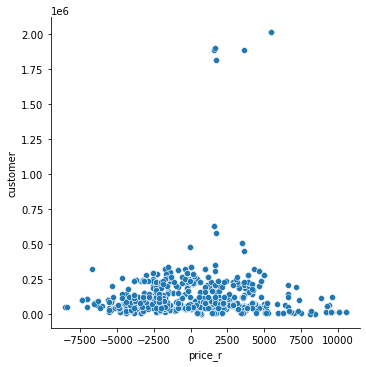

In [19]:
# 모든시장에 대한 산점도
Visualize_all('쇠고기(한우,불고기)','600g')

In [20]:
# 각 시장에 대해 상관계수값 구하고 지도에 시각화

# NaN : 분산이 0이다. 분포되어있지 않고 한곳에만 있어서 편차가 없다.
Visualize_each('쇠고기(한우,불고기)','600g')

C:\Users\123gu\anaconda3\envs\d8\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


   market_name      corr       p_value
0       상계중앙시장  0.176186  1.781133e-01
1     공릉동도깨비시장 -0.389393  2.104018e-03
2       자양골목시장       NaN           NaN
3      노룬산골목시장 -0.486675  1.537392e-01
4         경동시장 -0.488322  1.521431e-01
5      청량리종합시장  0.506969  1.347713e-01
6     방학동도깨비시장 -0.095074  7.938964e-01
7         동원시장 -0.055762  7.159940e-01
8       우림골목시장 -0.394463  8.057747e-03
9         대림시장  0.155018  7.399845e-01
10        대조시장  0.090880  8.161296e-01
11        망원시장  1.000000  0.000000e+00
12        None       NaN           NaN
13      고척근린시장 -0.709929  3.055927e-10
14       남구로시장 -0.200715  2.550322e-01
15      청담삼익시장  0.384772  2.620873e-03
16        도곡시장  0.478051  7.148266e-02
17        신영시장 -0.393498  2.957258e-03
18        인왕시장  0.006178  9.660360e-01
19        영천시장 -0.554031  9.435691e-06
20      화곡본동시장       NaN           NaN
21      송화골목시장 -0.858056  8.297460e-08
22      대림중앙시장 -0.325748  1.428852e-02
23     영등포전통시장  0.891926  1.688872e-02
24        신원시장 -0.929941 

(-0.554030684343447, 9.43569054956178e-06)


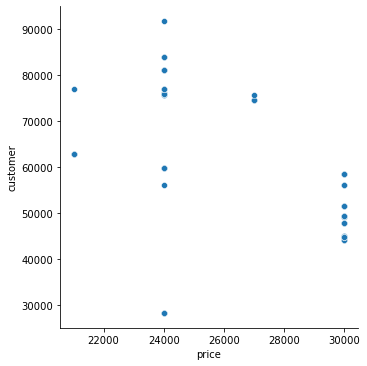

In [21]:
# 특정 시장의 산점도 확인
Visualize_market('쇠고기(한우,불고기)','600g','영천시장')

In [22]:
#df_treat = df[['시장이름','위도','경도','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']=='쇠고기(한우,불고기)')&(df['실판매규격']=='600g')&(df['년도']!=2020)&(df['년도']!=2019)].reset_index().drop(['index'], axis=1)
df_treat = df[['시장이름','위도','경도','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']=='쇠고기(한우,불고기)')&(df['실판매규격']=='600g')&(df['년도']!=2020)&(df['년도']!=2019)]  
df_gpp = df_treat.groupby(['시장이름','분기'])[['가격(원)']].mean().reset_index()

price_r = []
for i in range(len(df_treat['년도'])) :
    for j in range(len(df_gpp['분기'])):
        if list(df_treat['시장이름'])[i] == list(df_gpp['시장이름'])[j] and list(df_treat['분기'])[i] == list(df_gpp['분기'])[j] :
            price_r.append(list(df_treat['가격(원)'])[i] - list(df_gpp['가격(원)'])[j])

df_treat.insert(5, '상대가격', price_r)
df_treat = df_treat.drop(['년도-월'],axis=1)
df_treat = df_treat.drop_duplicates()
df_treat = df_treat.reset_index().drop(['index'], axis=1)

# outlier
quantile_25 = np.percentile(df_treat['가격(원)'].values, 25)
quantile_75 = np.percentile(df_treat['가격(원)'].values, 75)

IQR = quantile_75 - quantile_25
IQR_weight = IQR*1.5

lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight

df_treat = df_treat[(df_treat['가격(원)'] >= lowest)]
df_treat = df_treat[(df_treat['가격(원)'] <= highest)]

#corr
corr = pd.DataFrame(columns = ['market_name', 'corr', 'p_value', 'latitude', 'longitude'])
lat = []
lng = []
for i in range(len(df_treat['시장이름'].unique())):
    stat = []
    x = df_treat['가격(원)'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    y = df_treat['총_생활인구_수'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    name = df_treat['시장이름'].unique()
    
    lat.append(float(df_treat['위도'][df_treat['시장이름']==name[i]].unique()))
    lng.append(float(df_treat['경도'][df_treat['시장이름']==name[i]].unique()))
    
    if len(x)>2 and len(y)>2 :
        stat = stats.pearsonr(x,y)
        corr.loc[i] = [name[i], stat[0], stat[1], lat[i], lng[i]] 
    else :
        corr.loc[i] = [None, None, None,None,None]
        pass

#corr
corr = corr[corr['p_value'] != 0].dropna().reset_index()

center = [37.55, 126.986]
m = folium.Map(location=center, zoom_start=11, tiles='Open street map',  scrollWheelZoom=False, height='100%')

corr_p = corr[corr['corr']>0].reset_index()
corr_m = corr[corr['corr']<0].reset_index()

market_lat_p = corr_p['latitude']
market_lng_p = corr_p['longitude']

market_lat_m = corr_m['latitude']
market_lng_m = corr_m['longitude']

correlation_m = list(corr['corr'][corr['corr']<0])
correlation_p = list(corr['corr'][corr['corr']>0])

# +값
for i in range(len(corr_p['market_name'])):
    #tooltip =  f'● 시장이름: {corr['market_name'][i]} <br> ● 상관계수: {corr['corr'][i]}',    
    folium.CircleMarker(
        location = [market_lat_p[i], market_lng_p[i]],
        tooltip = [corr_p['market_name'][i],correlation_p[i]],
        radius = correlation_p[i]*50,
        fill=True,
        color='#3182bd',
        weight = 1,
        fill_color='#3182bd',
    ).add_to(m)

# -값    
for i in range(len(corr_m['market_name'])):
    #tooltip =  f'● 시장이름: {corr['market_name'][i]} <br> ● 상관계수: {corr['corr'][i]}',    
    folium.CircleMarker(
        location = [market_lat_m[i], market_lng_m[i]],
        tooltip = [corr_m['market_name'][i],correlation_m[i]],
        radius = correlation_m[i]*-50,
        fill=True,
        color = '#de2d26',
        weight = 1,
        fill_color='#de2d26',
    ).add_to(m)
    

m

C:\Users\123gu\anaconda3\envs\d8\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


### '돼지고기(생삼겹살)', market, '600g'

(-0.14554897557886942, 4.297179496479921e-09)


<ipython-input-58-e3f778ef5dce>:39: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_gpp = df_treat.groupby(['년도','분기'])['년도','분기','가격(원)'].mean()


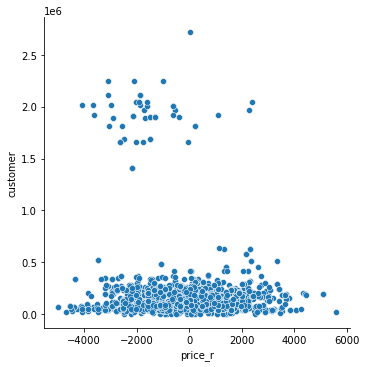

In [59]:
Visualize_all('돼지고기(생삼겹살)','600g')

In [23]:
#df_treat = df[['시장이름','위도','경도','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']=='쇠고기(한우,불고기)')&(df['실판매규격']=='600g')&(df['년도']!=2020)&(df['년도']!=2019)].reset_index().drop(['index'], axis=1)
df_treat = df[['시장이름','위도','경도','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']=='돼지고기(생삼겹살)')&(df['실판매규격']=='600g')&(df['년도']!=2020)&(df['년도']!=2019)]  
df_gpp = df_treat.groupby(['시장이름','분기'])[['가격(원)']].mean().reset_index()

price_r = []
for i in range(len(df_treat['년도'])) :
    for j in range(len(df_gpp['분기'])):
        if list(df_treat['시장이름'])[i] == list(df_gpp['시장이름'])[j] and list(df_treat['분기'])[i] == list(df_gpp['분기'])[j] :
            price_r.append(list(df_treat['가격(원)'])[i] - list(df_gpp['가격(원)'])[j])

df_treat.insert(5, '상대가격', price_r)
df_treat = df_treat.drop(['년도-월'],axis=1)
df_treat = df_treat.drop_duplicates()
df_treat = df_treat.reset_index().drop(['index'], axis=1)

# outlier
quantile_25 = np.percentile(df_treat['가격(원)'].values, 25)
quantile_75 = np.percentile(df_treat['가격(원)'].values, 75)

IQR = quantile_75 - quantile_25
IQR_weight = IQR*1.5

lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight

df_treat = df_treat[(df_treat['가격(원)'] >= lowest)]
df_treat = df_treat[(df_treat['가격(원)'] <= highest)]

#corr
corr = pd.DataFrame(columns = ['market_name', 'corr', 'p_value', 'latitude', 'longitude'])
lat = []
lng = []
for i in range(len(df_treat['시장이름'].unique())):
    stat = []
    x = df_treat['가격(원)'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    y = df_treat['총_생활인구_수'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    name = df_treat['시장이름'].unique()
    
    lat.append(float(df_treat['위도'][df_treat['시장이름']==name[i]].unique()))
    lng.append(float(df_treat['경도'][df_treat['시장이름']==name[i]].unique()))
    
    if len(x)>2 and len(y)>2 :
        stat = stats.pearsonr(x,y)
        corr.loc[i] = [name[i], stat[0], stat[1], lat[i], lng[i]] 
    else :
        corr.loc[i] = [None, None, None,None,None]
        pass

#corr
corr = corr[corr['p_value'] != 0].dropna().reset_index()

center = [37.55, 126.986]
m = folium.Map(location=center, zoom_start=11, tiles='Open street map',  scrollWheelZoom=False, height='100%')

corr_p = corr[corr['corr']>0].reset_index()
corr_m = corr[corr['corr']<0].reset_index()

market_lat_p = corr_p['latitude']
market_lng_p = corr_p['longitude']

market_lat_m = corr_m['latitude']
market_lng_m = corr_m['longitude']

correlation_m = list(corr['corr'][corr['corr']<0])
correlation_p = list(corr['corr'][corr['corr']>0])

# +값
for i in range(len(corr_p['market_name'])):
    #tooltip =  f'● 시장이름: {corr['market_name'][i]} <br> ● 상관계수: {corr['corr'][i]}',    
    folium.CircleMarker(
        location = [market_lat_p[i], market_lng_p[i]],
        tooltip = [corr_p['market_name'][i],correlation_p[i]],
        radius = correlation_p[i]*50,
        fill=True,
        color='#3182bd',
        weight = 1,
        fill_color='#3182bd',
    ).add_to(m)

# -값    
for i in range(len(corr_m['market_name'])):
    #tooltip =  f'● 시장이름: {corr['market_name'][i]} <br> ● 상관계수: {corr['corr'][i]}',    
    folium.CircleMarker(
        location = [market_lat_m[i], market_lng_m[i]],
        tooltip = [corr_m['market_name'][i],correlation_m[i]],
        radius = correlation_m[i]*-50,
        fill=True,
        color = '#de2d26',
        weight = 1,
        fill_color='#de2d26',
    ).add_to(m)
    

m

C:\Users\123gu\anaconda3\envs\d8\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


### 양파(1.5kg망) 

In [24]:
#df_treat = df[['시장이름','위도','경도','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']=='쇠고기(한우,불고기)')&(df['실판매규격']=='600g')&(df['년도']!=2020)&(df['년도']!=2019)].reset_index().drop(['index'], axis=1)
df_treat = df[['시장이름','위도','경도','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']=='양파(1.5kg망)')&(df['실판매규격']=='1망')&(df['년도']!=2020)&(df['년도']!=2019)]  
df_gpp = df_treat.groupby(['시장이름','분기'])[['가격(원)']].mean().reset_index()

price_r = []
for i in range(len(df_treat['년도'])) :
    for j in range(len(df_gpp['분기'])):
        if list(df_treat['시장이름'])[i] == list(df_gpp['시장이름'])[j] and list(df_treat['분기'])[i] == list(df_gpp['분기'])[j] :
            price_r.append(list(df_treat['가격(원)'])[i] - list(df_gpp['가격(원)'])[j])

df_treat.insert(5, '상대가격', price_r)
df_treat = df_treat.drop(['년도-월'],axis=1)
df_treat = df_treat.drop_duplicates()
df_treat = df_treat.reset_index().drop(['index'], axis=1)

# outlier
quantile_25 = np.percentile(df_treat['가격(원)'].values, 25)
quantile_75 = np.percentile(df_treat['가격(원)'].values, 75)

IQR = quantile_75 - quantile_25
IQR_weight = IQR*1.5

lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight

df_treat = df_treat[(df_treat['가격(원)'] >= lowest)]
df_treat = df_treat[(df_treat['가격(원)'] <= highest)]

#corr
corr = pd.DataFrame(columns = ['market_name', 'corr', 'p_value', 'latitude', 'longitude'])
lat = []
lng = []
for i in range(len(df_treat['시장이름'].unique())):
    stat = []
    x = df_treat['가격(원)'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    y = df_treat['총_생활인구_수'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    name = df_treat['시장이름'].unique()
    
    lat.append(float(df_treat['위도'][df_treat['시장이름']==name[i]].unique()))
    lng.append(float(df_treat['경도'][df_treat['시장이름']==name[i]].unique()))
    
    if len(x)>2 and len(y)>2 :
        stat = stats.pearsonr(x,y)
        corr.loc[i] = [name[i], stat[0], stat[1], lat[i], lng[i]] 
    else :
        corr.loc[i] = [None, None, None,None,None]
        pass

#corr
corr = corr[corr['p_value'] != 0].dropna().reset_index()

center = [37.55, 126.986]
m = folium.Map(location=center, zoom_start=11, tiles='Open street map',  scrollWheelZoom=False, height='100%')

corr_p = corr[corr['corr']>0].reset_index()
corr_m = corr[corr['corr']<0].reset_index()

market_lat_p = corr_p['latitude']
market_lng_p = corr_p['longitude']

market_lat_m = corr_m['latitude']
market_lng_m = corr_m['longitude']

correlation_m = list(corr['corr'][corr['corr']<0])
correlation_p = list(corr['corr'][corr['corr']>0])

# +값
for i in range(len(corr_p['market_name'])):
    #tooltip =  f'● 시장이름: {corr['market_name'][i]} <br> ● 상관계수: {corr['corr'][i]}',    
    folium.CircleMarker(
        location = [market_lat_p[i], market_lng_p[i]],
        tooltip = [corr_p['market_name'][i],correlation_p[i]],
        radius = correlation_p[i]*50,
        fill=True,
        color='#3182bd',
        weight = 1,
        fill_color='#3182bd',
    ).add_to(m)

# -값    
for i in range(len(corr_m['market_name'])):
    #tooltip =  f'● 시장이름: {corr['market_name'][i]} <br> ● 상관계수: {corr['corr'][i]}',    
    folium.CircleMarker(
        location = [market_lat_m[i], market_lng_m[i]],
        tooltip = [corr_m['market_name'][i],correlation_m[i]],
        radius = correlation_m[i]*-50,
        fill=True,
        color = '#de2d26',
        weight = 1,
        fill_color='#de2d26',
    ).add_to(m)
    

m

C:\Users\123gu\anaconda3\envs\d8\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


### '달걀(30개)' 30개

In [25]:
df_treat = df[['시장이름','위도','경도','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']=='달걀(30개)')&(df['실판매규격']=='30개')&(df['년도']!=2020)&(df['년도']!=2019)]  
df_gpp = df_treat.groupby(['시장이름','분기'])[['가격(원)']].mean().reset_index()

price_r = []
for i in range(len(df_treat['년도'])) :
    for j in range(len(df_gpp['분기'])):
        if list(df_treat['시장이름'])[i] == list(df_gpp['시장이름'])[j] and list(df_treat['분기'])[i] == list(df_gpp['분기'])[j] :
            price_r.append(list(df_treat['가격(원)'])[i] - list(df_gpp['가격(원)'])[j])

df_treat.insert(5, '상대가격', price_r)
df_treat = df_treat.drop(['년도-월'],axis=1)
df_treat = df_treat.drop_duplicates()
df_treat = df_treat.reset_index().drop(['index'], axis=1)

# outlier
quantile_25 = np.percentile(df_treat['가격(원)'].values, 25)
quantile_75 = np.percentile(df_treat['가격(원)'].values, 75)

IQR = quantile_75 - quantile_25
IQR_weight = IQR*1.5

lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight

df_treat = df_treat[(df_treat['가격(원)'] >= lowest)]
df_treat = df_treat[(df_treat['가격(원)'] <= highest)]

#corr
corr = pd.DataFrame(columns = ['market_name', 'corr', 'p_value', 'latitude', 'longitude'])
lat = []
lng = []
for i in range(len(df_treat['시장이름'].unique())):
    stat = []
    x = df_treat['가격(원)'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    y = df_treat['총_생활인구_수'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    name = df_treat['시장이름'].unique()
    
    lat.append(float(df_treat['위도'][df_treat['시장이름']==name[i]].unique()))
    lng.append(float(df_treat['경도'][df_treat['시장이름']==name[i]].unique()))
    
    if len(x)>2 and len(y)>2 :
        stat = stats.pearsonr(x,y)
        corr.loc[i] = [name[i], stat[0], stat[1], lat[i], lng[i]] 
    else :
        corr.loc[i] = [None, None, None,None,None]
        pass

#corr
corr = corr[corr['p_value'] != 0].dropna().reset_index()

center = [37.55, 126.986]
m = folium.Map(location=center, zoom_start=11, tiles='Open street map',  scrollWheelZoom=False, height='100%')

corr_p = corr[corr['corr']>0].reset_index()
corr_m = corr[corr['corr']<0].reset_index()

market_lat_p = corr_p['latitude']
market_lng_p = corr_p['longitude']

market_lat_m = corr_m['latitude']
market_lng_m = corr_m['longitude']

correlation_m = list(corr['corr'][corr['corr']<0])
correlation_p = list(corr['corr'][corr['corr']>0])

# +값
for i in range(len(corr_p['market_name'])):
    #tooltip =  f'● 시장이름: {corr['market_name'][i]} <br> ● 상관계수: {corr['corr'][i]}',    
    folium.CircleMarker(
        location = [market_lat_p[i], market_lng_p[i]],
        tooltip = [corr_p['market_name'][i],correlation_p[i]],
        radius = correlation_p[i]*50,
        fill=True,
        color='#3182bd',
        weight = 1,
        fill_color='#3182bd',
    ).add_to(m)

# -값    
for i in range(len(corr_m['market_name'])):
    #tooltip =  f'● 시장이름: {corr['market_name'][i]} <br> ● 상관계수: {corr['corr'][i]}',    
    folium.CircleMarker(
        location = [market_lat_m[i], market_lng_m[i]],
        tooltip = [corr_m['market_name'][i],correlation_m[i]],
        radius = correlation_m[i]*-50,
        fill=True,
        color = '#de2d26',
        weight = 1,
        fill_color='#de2d26',
    ).add_to(m)
    

m

### '고등어(생물,국산)' '1마리

In [26]:
df_treat = df[['시장이름','위도','경도','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']=='고등어(생물,국산)')&(df['실판매규격']=='1마리')&(df['년도']!=2020)&(df['년도']!=2019)]  
df_gpp = df_treat.groupby(['시장이름','분기'])[['가격(원)']].mean().reset_index()

price_r = []
for i in range(len(df_treat['년도'])) :
    for j in range(len(df_gpp['분기'])):
        if list(df_treat['시장이름'])[i] == list(df_gpp['시장이름'])[j] and list(df_treat['분기'])[i] == list(df_gpp['분기'])[j] :
            price_r.append(list(df_treat['가격(원)'])[i] - list(df_gpp['가격(원)'])[j])

df_treat.insert(5, '상대가격', price_r)
df_treat = df_treat.drop(['년도-월'],axis=1)
df_treat = df_treat.drop_duplicates()
df_treat = df_treat.reset_index().drop(['index'], axis=1)

# outlier
quantile_25 = np.percentile(df_treat['가격(원)'].values, 25)
quantile_75 = np.percentile(df_treat['가격(원)'].values, 75)

IQR = quantile_75 - quantile_25
IQR_weight = IQR*1.5

lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight

df_treat = df_treat[(df_treat['가격(원)'] >= lowest)]
df_treat = df_treat[(df_treat['가격(원)'] <= highest)]

#corr
corr = pd.DataFrame(columns = ['market_name', 'corr', 'p_value', 'latitude', 'longitude'])
lat = []
lng = []
for i in range(len(df_treat['시장이름'].unique())):
    stat = []
    x = df_treat['가격(원)'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    y = df_treat['총_생활인구_수'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    name = df_treat['시장이름'].unique()
    
    lat.append(float(df_treat['위도'][df_treat['시장이름']==name[i]].unique()))
    lng.append(float(df_treat['경도'][df_treat['시장이름']==name[i]].unique()))
    
    if len(x)>2 and len(y)>2 :
        stat = stats.pearsonr(x,y)
        corr.loc[i] = [name[i], stat[0], stat[1], lat[i], lng[i]] 
    else :
        corr.loc[i] = [None, None, None,None,None]
        pass

#corr
corr = corr[corr['p_value'] != 0].dropna().reset_index()

center = [37.55, 126.986]
m = folium.Map(location=center, zoom_start=11, tiles='Open street map',  scrollWheelZoom=False, height='100%')

corr_p = corr[corr['corr']>0].reset_index()
corr_m = corr[corr['corr']<0].reset_index()

market_lat_p = corr_p['latitude']
market_lng_p = corr_p['longitude']

market_lat_m = corr_m['latitude']
market_lng_m = corr_m['longitude']

correlation_m = list(corr['corr'][corr['corr']<0])
correlation_p = list(corr['corr'][corr['corr']>0])

# +값
for i in range(len(corr_p['market_name'])):
    #tooltip =  f'● 시장이름: {corr['market_name'][i]} <br> ● 상관계수: {corr['corr'][i]}',    
    folium.CircleMarker(
        location = [market_lat_p[i], market_lng_p[i]],
        tooltip = [corr_p['market_name'][i],correlation_p[i]],
        radius = correlation_p[i]*50,
        fill=True,
        color='#3182bd',
        weight = 1,
        fill_color='#3182bd',
    ).add_to(m)

# -값    
for i in range(len(corr_m['market_name'])):
    #tooltip =  f'● 시장이름: {corr['market_name'][i]} <br> ● 상관계수: {corr['corr'][i]}',    
    folium.CircleMarker(
        location = [market_lat_m[i], market_lng_m[i]],
        tooltip = [corr_m['market_name'][i],correlation_m[i]],
        radius = correlation_m[i]*-50,
        fill=True,
        color = '#de2d26',
        weight = 1,
        fill_color='#de2d26',
    ).add_to(m)
    

m

C:\Users\123gu\anaconda3\envs\d8\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


### '무(1kg)'  1개

In [27]:
df_treat = df[['시장이름','위도','경도','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']=='무(1kg)')&(df['실판매규격']=='1개')&(df['년도']!=2020)&(df['년도']!=2019)]  
df_gpp = df_treat.groupby(['시장이름','분기'])[['가격(원)']].mean().reset_index()

price_r = []
for i in range(len(df_treat['년도'])) :
    for j in range(len(df_gpp['분기'])):
        if list(df_treat['시장이름'])[i] == list(df_gpp['시장이름'])[j] and list(df_treat['분기'])[i] == list(df_gpp['분기'])[j] :
            price_r.append(list(df_treat['가격(원)'])[i] - list(df_gpp['가격(원)'])[j])

df_treat.insert(5, '상대가격', price_r)
df_treat = df_treat.drop(['년도-월'],axis=1)
df_treat = df_treat.drop_duplicates()
df_treat = df_treat.reset_index().drop(['index'], axis=1)

# outlier
quantile_25 = np.percentile(df_treat['가격(원)'].values, 25)
quantile_75 = np.percentile(df_treat['가격(원)'].values, 75)

IQR = quantile_75 - quantile_25
IQR_weight = IQR*1.5

lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight

df_treat = df_treat[(df_treat['가격(원)'] >= lowest)]
df_treat = df_treat[(df_treat['가격(원)'] <= highest)]

#corr
corr = pd.DataFrame(columns = ['market_name', 'corr', 'p_value', 'latitude', 'longitude'])
lat = []
lng = []
for i in range(len(df_treat['시장이름'].unique())):
    stat = []
    x = df_treat['가격(원)'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    y = df_treat['총_생활인구_수'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    name = df_treat['시장이름'].unique()
    
    lat.append(float(df_treat['위도'][df_treat['시장이름']==name[i]].unique()))
    lng.append(float(df_treat['경도'][df_treat['시장이름']==name[i]].unique()))
    
    if len(x)>2 and len(y)>2 :
        stat = stats.pearsonr(x,y)
        corr.loc[i] = [name[i], stat[0], stat[1], lat[i], lng[i]] 
    else :
        corr.loc[i] = [None, None, None,None,None]
        pass

#corr
corr = corr[corr['p_value'] != 0].dropna().reset_index()

center = [37.55, 126.986]
m = folium.Map(location=center, zoom_start=11, tiles='Open street map',  scrollWheelZoom=False, height='100%')

corr_p = corr[corr['corr']>0].reset_index()
corr_m = corr[corr['corr']<0].reset_index()

market_lat_p = corr_p['latitude']
market_lng_p = corr_p['longitude']

market_lat_m = corr_m['latitude']
market_lng_m = corr_m['longitude']

correlation_m = list(corr['corr'][corr['corr']<0])
correlation_p = list(corr['corr'][corr['corr']>0])

# +값
for i in range(len(corr_p['market_name'])):
    #tooltip =  f'● 시장이름: {corr['market_name'][i]} <br> ● 상관계수: {corr['corr'][i]}',    
    folium.CircleMarker(
        location = [market_lat_p[i], market_lng_p[i]],
        tooltip = [corr_p['market_name'][i],correlation_p[i]],
        radius = correlation_p[i]*50,
        fill=True,
        color='#3182bd',
        weight = 1,
        fill_color='#3182bd',
    ).add_to(m)

# -값    
for i in range(len(corr_m['market_name'])):
    #tooltip =  f'● 시장이름: {corr['market_name'][i]} <br> ● 상관계수: {corr['corr'][i]}',    
    folium.CircleMarker(
        location = [market_lat_m[i], market_lng_m[i]],
        tooltip = [corr_m['market_name'][i],correlation_m[i]],
        radius = correlation_m[i]*-50,
        fill=True,
        color = '#de2d26',
        weight = 1,
        fill_color='#de2d26',
    ).add_to(m)
    

m

### '조기(냉동,수입산)' 1마리

In [28]:
df_treat = df[['시장이름','위도','경도','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']=='조기(냉동,수입산)')&(df['실판매규격']=='1마리')&(df['년도']!=2020)&(df['년도']!=2019)]  
df_gpp = df_treat.groupby(['시장이름','분기'])[['가격(원)']].mean().reset_index()

price_r = []
for i in range(len(df_treat['년도'])) :
    for j in range(len(df_gpp['분기'])):
        if list(df_treat['시장이름'])[i] == list(df_gpp['시장이름'])[j] and list(df_treat['분기'])[i] == list(df_gpp['분기'])[j] :
            price_r.append(list(df_treat['가격(원)'])[i] - list(df_gpp['가격(원)'])[j])

df_treat.insert(5, '상대가격', price_r)
df_treat = df_treat.drop(['년도-월'],axis=1)
df_treat = df_treat.drop_duplicates()
df_treat = df_treat.reset_index().drop(['index'], axis=1)

# outlier
quantile_25 = np.percentile(df_treat['가격(원)'].values, 25)
quantile_75 = np.percentile(df_treat['가격(원)'].values, 75)

IQR = quantile_75 - quantile_25
IQR_weight = IQR*1.5

lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight

df_treat = df_treat[(df_treat['가격(원)'] >= lowest)]
df_treat = df_treat[(df_treat['가격(원)'] <= highest)]

#corr
corr = pd.DataFrame(columns = ['market_name', 'corr', 'p_value', 'latitude', 'longitude'])
lat = []
lng = []
for i in range(len(df_treat['시장이름'].unique())):
    stat = []
    x = df_treat['가격(원)'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    y = df_treat['총_생활인구_수'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    name = df_treat['시장이름'].unique()
    
    lat.append(float(df_treat['위도'][df_treat['시장이름']==name[i]].unique()))
    lng.append(float(df_treat['경도'][df_treat['시장이름']==name[i]].unique()))
    
    if len(x)>2 and len(y)>2 :
        stat = stats.pearsonr(x,y)
        corr.loc[i] = [name[i], stat[0], stat[1], lat[i], lng[i]] 
    else :
        corr.loc[i] = [None, None, None,None,None]
        pass

#corr
corr = corr[corr['p_value'] != 0].dropna().reset_index()

center = [37.55, 126.986]
m = folium.Map(location=center, zoom_start=11, tiles='Open street map',  scrollWheelZoom=False, height='100%')

corr_p = corr[corr['corr']>0].reset_index()
corr_m = corr[corr['corr']<0].reset_index()

market_lat_p = corr_p['latitude']
market_lng_p = corr_p['longitude']

market_lat_m = corr_m['latitude']
market_lng_m = corr_m['longitude']

correlation_m = list(corr['corr'][corr['corr']<0])
correlation_p = list(corr['corr'][corr['corr']>0])

# +값
for i in range(len(corr_p['market_name'])):
    #tooltip =  f'● 시장이름: {corr['market_name'][i]} <br> ● 상관계수: {corr['corr'][i]}',    
    folium.CircleMarker(
        location = [market_lat_p[i], market_lng_p[i]],
        tooltip = [corr_p['market_name'][i],correlation_p[i]],
        radius = correlation_p[i]*50,
        fill=True,
        color='#3182bd',
        weight = 1,
        fill_color='#3182bd',
    ).add_to(m)

# -값    
for i in range(len(corr_m['market_name'])):
    #tooltip =  f'● 시장이름: {corr['market_name'][i]} <br> ● 상관계수: {corr['corr'][i]}',    
    folium.CircleMarker(
        location = [market_lat_m[i], market_lng_m[i]],
        tooltip = [corr_m['market_name'][i],correlation_m[i]],
        radius = correlation_m[i]*-50,
        fill=True,
        color = '#de2d26',
        weight = 1,
        fill_color='#de2d26',
    ).add_to(m)
    

m

#### 품목별, 시장별로 데이터 확인

In [29]:
df[['시장이름','년도','분기','년도-월','가격(원)','실판매규격','총_생활인구_수']][(df['품목이름']=='돼지고기(생삼겹살)')&(df['실판매규격']=='600g')&(df['년도']!=2020)&(df['년도']!=2019)&(df['시장이름']=='현대시장')]

,시장이름,년도,분기,년도-월,가격(원),실판매규격,총_생활인구_수
142980,현대시장,2014,3,2014-08,9500,600g,523030.0
143475,현대시장,2014,3,2014-07,9500,600g,523030.0
144129,현대시장,2014,2,2014-06,9000,600g,333976.0
144892,현대시장,2014,2,2014-05,8000,600g,333976.0
145610,현대시장,2014,2,2014-04,8000,600g,333976.0
146376,현대시장,2014,1,2014-03,8000,600g,338277.0
147078,현대시장,2014,1,2014-02,8000,600g,338277.0
147668,현대시장,2014,1,2014-01,8000,600g,338277.0


In [30]:
df[['시장이름','년도','분기','년도-월','가격(원)','실판매규격','총_생활인구_수']][(df['품목이름']=='돼지고기(생삼겹살)')&(df['실판매규격']=='600g')&(df['년도']!=2020)&(df['년도']!=2019)&(df['시장이름']=='돈암제일시장')]

,시장이름,년도,분기,년도-월,가격(원),실판매규격,총_생활인구_수
143681,돈암제일시장,2014,3,2014-07,14100,600g,632242.0
143937,돈암제일시장,2014,2,2014-06,13680,600g,410423.0
144766,돈암제일시장,2014,2,2014-05,13800,600g,410423.0
145451,돈암제일시장,2014,2,2014-04,11800,600g,410423.0
145993,돈암제일시장,2014,1,2014-03,12000,600g,298895.0
147046,돈암제일시장,2014,1,2014-02,9600,600g,298895.0
147398,돈암제일시장,2014,1,2014-01,9600,600g,298895.0


In [31]:
df[['시장이름','년도','분기','년도-월','가격(원)','실판매규격','총_생활인구_수']][(df['품목이름']=='돼지고기(생삼겹살)')&(df['실판매규격']=='600g')&(df['년도']!=2020)&(df['년도']!=2019)&(df['시장이름']=='현대시장')]

,시장이름,년도,분기,년도-월,가격(원),실판매규격,총_생활인구_수
142980,현대시장,2014,3,2014-08,9500,600g,523030.0
143475,현대시장,2014,3,2014-07,9500,600g,523030.0
144129,현대시장,2014,2,2014-06,9000,600g,333976.0
144892,현대시장,2014,2,2014-05,8000,600g,333976.0
145610,현대시장,2014,2,2014-04,8000,600g,333976.0
146376,현대시장,2014,1,2014-03,8000,600g,338277.0
147078,현대시장,2014,1,2014-02,8000,600g,338277.0
147668,현대시장,2014,1,2014-01,8000,600g,338277.0


In [32]:
df[['시장이름','년도','분기','년도-월','가격(원)','실판매규격','총_생활인구_수']][(df['품목이름']=='돼지고기(생삼겹살)')&(df['실판매규격']=='600g')&(df['시장이름']=='인헌시장')]

,시장이름,년도,분기,년도-월,가격(원),실판매규격,총_생활인구_수
1572,인헌시장,2020,4,2020-12,14800,600g,346670.0
3388,인헌시장,2020,4,2020-12,14800,600g,346670.0
3395,인헌시장,2020,4,2020-12,14800,600g,346670.0
4316,인헌시장,2020,4,2020-12,14800,600g,346670.0
4594,인헌시장,2020,4,2020-12,14800,600g,346670.0
5354,인헌시장,2020,4,2020-11,14800,600g,346670.0
5359,인헌시장,2020,4,2020-11,14800,600g,346670.0
6175,인헌시장,2020,4,2020-11,14800,600g,346670.0
6191,인헌시장,2020,4,2020-11,14800,600g,346670.0
6195,인헌시장,2020,4,2020-11,14800,600g,346670.0


tooltip =  f'● 정류장명: {name[i]} <br> ● 환경지수: {eco[i]} <br> ● 근처 노인복지시설: {senior[i]} <br> ● 승차인원수:{population[i]}'
    

# 혜빈님 시각화 작업

dataframe 필요하시면 아래코드 사용하시면 됩니다. 제일 첫번째줄에 품목이름, 실판매규격만 저희가 다룰 품목에 맞춰서 넣어주시면 해당 데이터 프레임 이상치 제거 알아서 해줘서 만들어집니다.  

혹시 성별 연령별 등등 500개가 넘는 열들이 필요하시면 

df_treat = df[(df['품목이름']=='조기(냉동,수입산)')&(df['실판매규격']=='1마리')&(df['년도']!=2020)&(df['년도']!=2019)]  

첫번째 줄을 위 코드로 바꿔주세요~

In [69]:
df_treat = df[['시장이름','위도','경도','분기','년도','년도-월','가격(원)','총_생활인구_수']][(df['품목이름']=='조기(냉동,수입산)')&(df['실판매규격']=='1마리')&(df['년도']!=2020)&(df['년도']!=2019)]  
df_gpp = df_treat.groupby(['시장이름','분기'])[['가격(원)']].mean().reset_index()

price_r = []
for i in range(len(df_treat['년도'])) :
    for j in range(len(df_gpp['분기'])):
        if list(df_treat['시장이름'])[i] == list(df_gpp['시장이름'])[j] and list(df_treat['분기'])[i] == list(df_gpp['분기'])[j] :
            price_r.append(list(df_treat['가격(원)'])[i] - list(df_gpp['가격(원)'])[j])

df_treat.insert(5, '상대가격', price_r)
#df_treat = df_treat.drop(['년도-월'],axis=1)
df_treat = df_treat.drop_duplicates()
df_treat = df_treat.reset_index().drop(['index'], axis=1)

# outlier
quantile_25 = np.percentile(df_treat['가격(원)'].values, 25)
quantile_75 = np.percentile(df_treat['가격(원)'].values, 75)

IQR = quantile_75 - quantile_25
IQR_weight = IQR*1.5

lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight

df_treat = df_treat[(df_treat['가격(원)'] >= lowest)]
df_treat = df_treat[(df_treat['가격(원)'] <= highest)]

df_treat

,시장이름,위도,경도,분기,년도,상대가격,년도-월,가격(원),총_생활인구_수
0,광장시장,37.570019,126.998885,4,2018,0.000000,2018-12,2000,135386.0
1,통인시장,37.580818,126.968708,4,2018,0.000000,2018-12,3500,106496.0
2,서울중앙시장,37.566763,127.019773,4,2018,166.666667,2018-12,3500,325624.0
3,남대문시장,37.559373,126.977933,4,2018,733.333333,2018-12,4000,930822.0
4,관악신사시장,37.486291,126.916954,4,2018,0.000000,2018-12,2000,72921.0
5,사당시장,37.482842,126.974981,4,2018,0.000000,2018-12,2000,50952.0
6,숭인시장,37.613201,127.029426,4,2018,-446.666667,2018-12,3330,47902.0
7,수유전통시장,37.631638,127.021810,4,2018,333.333333,2018-12,5000,114153.0
8,신영시장,37.533219,126.835402,4,2018,762.000000,2018-12,2500,52898.0
9,목3동시장,37.548263,126.866815,4,2018,0.000000,2018-12,1428,197820.0


In [68]:
# 시장별 확인하고 싶으시면..
df_treat[df_treat['시장이름'] == '공릉동도깨비시장']

,시장이름,위도,경도,분기,년도,상대가격,가격(원),총_생활인구_수
35,공릉동도깨비시장,37.622888,127.07724,3,2018,-571.428571,4000,84464.0
101,공릉동도깨비시장,37.622888,127.07724,3,2017,1428.571429,6000,69882.0
105,공릉동도깨비시장,37.622888,127.07724,3,2017,428.571429,5000,69882.0
110,공릉동도깨비시장,37.622888,127.07724,2,2017,166.666667,5000,57859.0
114,공릉동도깨비시장,37.622888,127.07724,2,2017,1166.666667,6000,57859.0
120,공릉동도깨비시장,37.622888,127.07724,1,2017,1166.666667,6000,100264.0
123,공릉동도깨비시장,37.622888,127.07724,1,2017,166.666667,5000,100264.0
126,공릉동도깨비시장,37.622888,127.07724,4,2016,-800.000000,3000,125103.0
130,공릉동도깨비시장,37.622888,127.07724,4,2016,1200.000000,5000,125103.0
132,공릉동도깨비시장,37.622888,127.07724,3,2016,-571.428571,4000,85879.0


#### 혹시 상관계수값 필요하시면..

In [62]:
corr = pd.DataFrame(columns = ['market_name', 'corr', 'p_value', 'latitude', 'longitude'])
lat = []
lng = []
for i in range(len(df_treat['시장이름'].unique())):
    stat = []
    x = df_treat['가격(원)'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    y = df_treat['총_생활인구_수'][df_treat['시장이름']==df_treat['시장이름'].unique()[i]]
    name = df_treat['시장이름'].unique()
    
    lat.append(float(df_treat['위도'][df_treat['시장이름']==name[i]].unique()))
    lng.append(float(df_treat['경도'][df_treat['시장이름']==name[i]].unique()))
    
    if len(x)>2 and len(y)>2 :
        stat = stats.pearsonr(x,y)
        corr.loc[i] = [name[i], stat[0], stat[1], lat[i], lng[i]] 
    else :
        corr.loc[i] = [None, None, None,None,None]
        pass
    
corr = corr[corr['p_value'] != 0].dropna().reset_index()
corr

,index,market_name,corr,p_value,latitude,longitude
0,0,광장시장,-0.131006,0.804615,37.570019,126.998885
1,1,통인시장,-0.653728,0.159096,37.580818,126.968708
2,2,서울중앙시장,0.751336,0.031627,37.566763,127.019773
3,3,남대문시장,-0.383130,0.158658,37.559373,126.977933
4,4,관악신사시장,-0.159696,0.797536,37.486291,126.916954
5,5,사당시장,-0.554241,0.253765,37.482842,126.974981
6,6,숭인시장,-0.152722,0.772699,37.613201,127.029426
7,7,수유전통시장,-0.206489,0.694669,37.631638,127.021810
8,8,신영시장,-0.494848,0.036813,37.533219,126.835402
9,10,암사종합시장,0.114837,0.786567,37.550849,127.128769


### 품목별로 전체시장 산점도, 시장별 상관계수 출력  

만드는건 오래 걸렸는데 전체시장 산점도가 씨잘데기 없이 나와서 쓸일 없을듯 합니다. 아마 이 아래로 삭제예정.

### '돼지고기(생삼겹살)', market, '600g'

(-0.14554897557886942, 4.297179496479921e-09)


<ipython-input-18-ec81dd1c2cc9>:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_gpp = df_treat.groupby(['년도','분기'])['년도','분기','가격(원)'].mean()


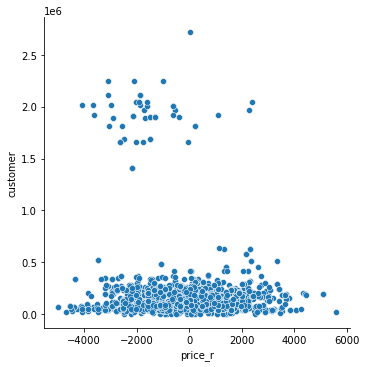

In [34]:
Visualize_all('돼지고기(생삼겹살)','600g')

In [35]:
Visualize_each('돼지고기(생삼겹살)','600g')

   market_name      corr   p_value
0         금남시장  0.111854  0.602816
1       상계중앙시장  0.548712  0.000006
2     공릉동도깨비시장 -0.375214  0.003137
3         광장시장 -0.103094  0.437153
4         통인시장  0.259954  0.044871
5       자양골목시장  0.305806  0.113518
6      노룬산골목시장  0.072415  0.592434
7         경동시장 -0.057251  0.663933
8      청량리종합시장  0.134152  0.306825
9       관악신사시장  0.189920  0.146104
10        사당시장  0.150853  0.677416
11        방이시장  0.223413  0.088957
12        마천시장  0.514780  0.000036
13        동원시장 -0.039475  0.764592
14      우림골목시장 -0.575253  0.000002
15        None       NaN       NaN
16      수유전통시장 -0.225327  0.091942
17        망원시장  0.286424  0.029276
18    마포농수산물시장  0.326310  0.073204
19      송화골목시장 -0.476365  0.000119
20      화곡본동시장 -0.052090  0.695193
21      고척근린시장 -0.035465  0.787917
22       남구로시장 -0.123215  0.420030
23        신원시장  0.315971  0.373785
24        인헌시장 -0.043591  0.740865
25       목3동시장 -0.442987  0.003725
26      대림중앙시장 -0.192827  0.158399
27     영등포전통시장  0.18

C:\Users\123gu\anaconda3\envs\d8\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


### '달걀(30개)', market, '30개'

<ipython-input-18-ec81dd1c2cc9>:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_gpp = df_treat.groupby(['년도','분기'])['년도','분기','가격(원)'].mean()


(0.047941087779047015, 0.15184308731865262)


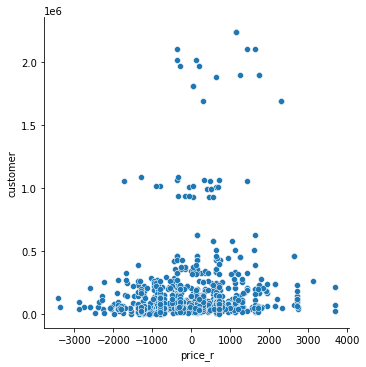

In [36]:
Visualize_all('달걀(30개)','30개')

### '양파(1.5kg망)', market, '1망'

(-0.017404605382891295, 0.5832581029991376)


<ipython-input-18-ec81dd1c2cc9>:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_gpp = df_treat.groupby(['년도','분기'])['년도','분기','가격(원)'].mean()


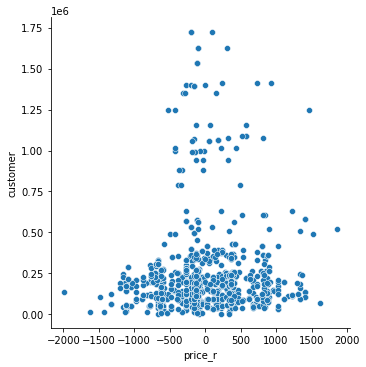

In [37]:
Visualize_all('양파(1.5kg망)','1망')

### '무(1kg)', market, '1개'

(-0.10700082507330341, 4.533714755305613e-05)


<ipython-input-18-ec81dd1c2cc9>:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_gpp = df_treat.groupby(['년도','분기'])['년도','분기','가격(원)'].mean()


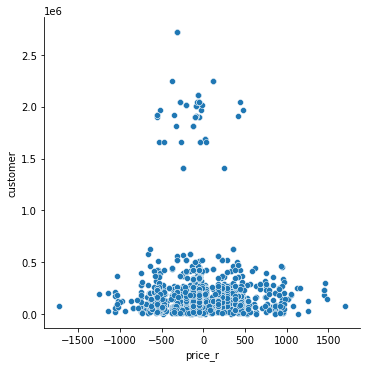

In [38]:
Visualize_all('무(1kg)','1개')

### '고등어(생물,국산)', market, '1마리'

(-0.1640127956569335, 0.006916978172331728)


<ipython-input-18-ec81dd1c2cc9>:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_gpp = df_treat.groupby(['년도','분기'])['년도','분기','가격(원)'].mean()


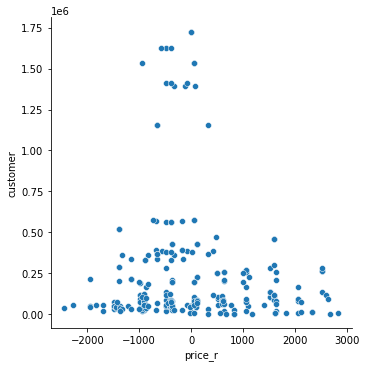

In [39]:
Visualize_all('고등어(생물,국산)','1마리')

### '조기(냉동,수입산)', market, '1마리'

(-0.1252853108197874, 0.03786194348435843)


<ipython-input-18-ec81dd1c2cc9>:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_gpp = df_treat.groupby(['년도','분기'])['년도','분기','가격(원)'].mean()


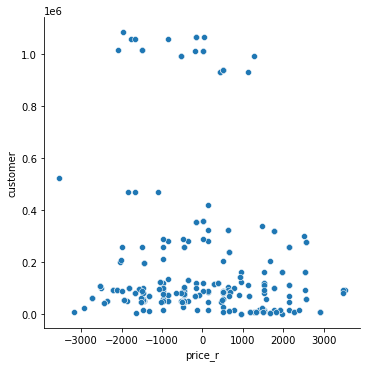

In [40]:
Visualize_all('조기(냉동,수입산)','1마리')

#### 18 -> 19,20  단절구간 확인

In [41]:
Visualize_each('오이(다다기)','1개')

   market_name      corr   p_value
0         금남시장 -0.076046  0.581072
1       상계중앙시장  0.156844  0.321225
2     공릉동도깨비시장 -0.177890  0.173887
3       서울중앙시장 -0.247099  0.059191
4        남대문시장 -0.369215  0.004005
5         후암시장  0.083481  0.525984
6       자양골목시장  0.011482  0.949434
7         경동시장 -0.158997  0.224972
8      청량리종합시장 -0.023486  0.858629
9       돈암제일시장  0.075214  0.720850
10    방학동도깨비시장 -0.017409  0.894965
11        현대시장  0.026978  0.847937
12        남문시장 -0.179725  0.180976
13      관악신사시장  0.172224  0.192117
14        사당시장  0.207239  0.112105
15        방이시장  0.160704  0.224021
16        마천시장  0.079466  0.546145
17        동원시장 -0.324621  0.013753
18      우림골목시장  0.035520  0.791234
19        None       NaN       NaN
20      수유전통시장 -0.555127  0.000004
21        대조시장 -0.023159  0.903314
22        영천시장  0.100617  0.444317
23        인왕시장  0.146818  0.262967
24        망원시장 -0.021660  0.870647
25    마포농수산물시장  0.018143  0.920173
26      송화골목시장 -0.064086  0.629653
27      화곡본동시장 -0.06

(-0.1151224254941497, 0.3981773160091007)


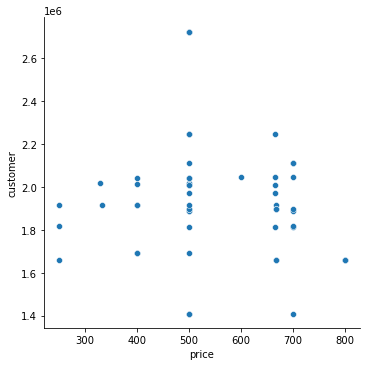

In [42]:
Visualize_market('오이(다다기)','1개','영등포전통시장')

In [43]:
df_check = df[['시장이름','년도','분기','가격(원)','실판매규격','총_생활인구_수']][df['품목이름']=='오이(다다기)']
df_check = df_check[df_check['실판매규격']=='1개'].reset_index()
df_check = df_check[df_check['시장이름']=='영등포전통시장'].reset_index()
df_check

,level_0,index,시장이름,년도,분기,가격(원),실판매규격,총_생활인구_수
0,495,20626,영등포전통시장,2020,3,1000,1개,1329206.0
1,586,22242,영등포전통시장,2020,3,1000,1개,1329206.0
2,587,22257,영등포전통시장,2020,3,1000,1개,1329206.0
3,588,22263,영등포전통시장,2020,3,1000,1개,1329206.0
4,589,22289,영등포전통시장,2020,3,1000,1개,1329206.0
5,590,22304,영등포전통시장,2020,3,1000,1개,1329206.0
6,948,29862,영등포전통시장,2020,3,666,1개,1329206.0
7,949,29872,영등포전통시장,2020,3,666,1개,1329206.0
8,950,29887,영등포전통시장,2020,3,500,1개,1329206.0
9,951,29910,영등포전통시장,2020,3,666,1개,1329206.0


(0.17928067442299986, 0.2620444127376195)


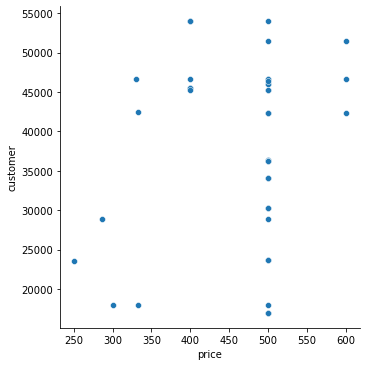

In [44]:
Visualize_market('오이(다다기)','1개','대림중앙시장')

In [45]:
df_check = df[['시장이름','년도','분기','가격(원)','실판매규격','총_생활인구_수']][df['품목이름']=='오이(다다기)']
df_check = df_check[df_check['실판매규격']=='1개'].reset_index()
df_check = df_check[df_check['시장이름']=='대림중앙시장'].reset_index()
df_check

,level_0,index,시장이름,년도,분기,가격(원),실판매규격,총_생활인구_수
0,496,20635,대림중앙시장,2020,3,1000,1개,119292.0
1,562,21792,대림중앙시장,2020,3,1200,1개,119292.0
2,563,21811,대림중앙시장,2020,3,1000,1개,119292.0
3,564,21834,대림중앙시장,2020,3,666,1개,119292.0
4,565,21845,대림중앙시장,2020,3,1000,1개,119292.0
5,566,21847,대림중앙시장,2020,3,666,1개,119292.0
6,898,29003,대림중앙시장,2020,3,500,1개,119292.0
7,899,29019,대림중앙시장,2020,3,500,1개,119292.0
8,900,29030,대림중앙시장,2020,3,666,1개,119292.0
9,901,29047,대림중앙시장,2020,3,666,1개,119292.0


(-0.1778900757411867, 0.17388742115928868)


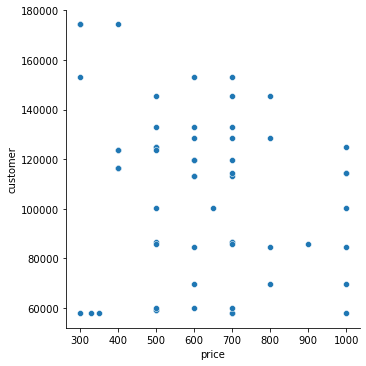

In [46]:
Visualize_market('오이(다다기)','1개','공릉동도깨비시장')

In [47]:
df_check = df[['시장이름','년도','분기','가격(원)','실판매규격','총_생활인구_수']][df['품목이름']=='오이(다다기)']
df_check = df_check[df_check['실판매규격']=='1개'].reset_index()
df_check = df_check[df_check['시장이름']=='공릉동도깨비시장'].reset_index()
df_check

,level_0,index,시장이름,년도,분기,가격(원),실판매규격,총_생활인구_수
0,37,2148,공릉동도깨비시장,2020,4,800,1개,355235.0
1,38,2175,공릉동도깨비시장,2020,4,600,1개,355235.0
2,39,2184,공릉동도깨비시장,2020,4,700,1개,355235.0
3,40,2220,공릉동도깨비시장,2020,4,700,1개,355235.0
4,43,2307,공릉동도깨비시장,2020,4,600,1개,355235.0
5,44,2326,공릉동도깨비시장,2020,4,600,1개,355235.0
6,119,4804,공릉동도깨비시장,2020,4,500,1개,355235.0
7,178,6789,공릉동도깨비시장,2020,4,600,1개,355235.0
8,179,6799,공릉동도깨비시장,2020,4,500,1개,355235.0
9,180,6895,공릉동도깨비시장,2020,4,500,1개,355235.0


(0.15684364934133682, 0.3212247147475043)


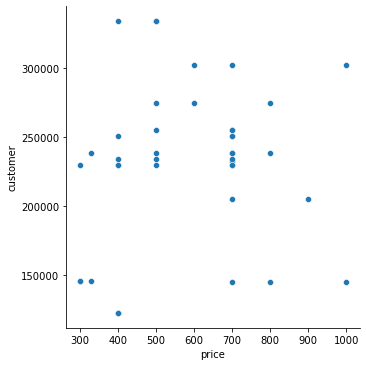

In [48]:
Visualize_market('오이(다다기)','1개','상계중앙시장')

In [49]:
df_check = df[['시장이름','년도','분기','가격(원)','실판매규격','총_생활인구_수']][df['품목이름']=='오이(다다기)']
df_check = df_check[df_check['실판매규격']=='1개'].reset_index()
df_check = df_check[df_check['시장이름']=='상계중앙시장'].reset_index()
df_check

,level_0,index,시장이름,년도,분기,가격(원),실판매규격,총_생활인구_수
0,87,4107,상계중앙시장,2020,4,800,1개,999759.0
1,88,4117,상계중앙시장,2020,4,600,1개,999759.0
2,89,4133,상계중앙시장,2020,4,600,1개,999759.0
3,90,4164,상계중앙시장,2020,4,700,1개,999759.0
4,91,4170,상계중앙시장,2020,4,700,1개,999759.0
5,92,4192,상계중앙시장,2020,4,600,1개,999759.0
6,193,7237,상계중앙시장,2020,4,500,1개,999759.0
7,194,7254,상계중앙시장,2020,4,500,1개,999759.0
8,195,7294,상계중앙시장,2020,4,600,1개,999759.0
9,196,7333,상계중앙시장,2020,4,500,1개,999759.0


In [50]:
Visualize_each('무(1kg)','1개')

   market_name      corr   p_value
0       상계중앙시장  0.205573  0.125006
1     공릉동도깨비시장 -0.471047  0.000217
2         후암시장 -0.251062  0.059595
3       자양골목시장  0.145598  0.426552
4      노룬산골목시장  0.012363  0.926614
5         경동시장 -0.189573  0.423417
6      청량리종합시장 -0.168789  0.689479
7         현대시장  0.078482  0.591943
8         남문시장 -0.495058  0.000078
9       관악신사시장  0.061488  0.875132
10        사당시장  0.115563  0.785240
11        동원시장  0.166777  0.273524
12      우림골목시장 -0.050517  0.744686
13        숭인시장  0.451773  0.189948
14      수유전통시장  0.092249  0.799914
15        영천시장 -0.441114  0.321819
16        인왕시장 -0.047083  0.920159
17      송화골목시장 -0.363825  0.012937
18      화곡본동시장  0.156083  0.255143
19        신원시장  0.054744  0.680478
20        인헌시장 -0.525585  0.000089
21      청담삼익시장  0.050575  0.738538
22        도곡시장 -0.036162  0.886723
23        신영시장 -0.394891  0.002157
24       목3동시장 -0.204478  0.123639
25      암사종합시장 -0.167971  0.229265
26    마포농수산물시장  0.442626  0.149599
27        망원시장  0.19

In [51]:
df_check = df[['시장이름','년도','분기','가격(원)','실판매규격','총_생활인구_수']][df['품목이름']=='무(1kg)']
df_check = df_check[df_check['실판매규격']=='1개'].reset_index()
df_check = df_check[df_check['시장이름']=='청담삼익시장'].reset_index()
df_check

,level_0,index,시장이름,년도,분기,가격(원),실판매규격,총_생활인구_수
0,276,20047,청담삼익시장,2020,3,3980,1개,37698.0
1,359,23050,청담삼익시장,2020,3,2580,1개,37698.0
2,360,23075,청담삼익시장,2020,3,2580,1개,37698.0
3,361,23089,청담삼익시장,2020,3,2580,1개,37698.0
4,362,23114,청담삼익시장,2020,3,2580,1개,37698.0
5,363,23120,청담삼익시장,2020,3,2580,1개,37698.0
6,408,24355,청담삼익시장,2020,3,2580,1개,37698.0
7,409,24391,청담삼익시장,2020,3,2580,1개,37698.0
8,410,24403,청담삼익시장,2020,3,2380,1개,37698.0
9,411,24418,청담삼익시장,2020,3,2380,1개,37698.0


In [52]:
df_check = df[['시장이름','년도','분기','가격(원)','실판매규격','총_생활인구_수']][df['품목이름']=='무(1kg)']
df_check = df_check[df_check['실판매규격']=='1개'].reset_index()
df_check = df_check[df_check['시장이름']=='목3동시장'].reset_index()
df_check

,level_0,index,시장이름,년도,분기,가격(원),실판매규격,총_생활인구_수
0,258,19109,목3동시장,2020,3,3500,1개,430599.0
1,299,21088,목3동시장,2020,3,2000,1개,430599.0
2,301,21132,목3동시장,2020,3,2000,1개,430599.0
3,303,21199,목3동시장,2020,3,1500,1개,430599.0
4,304,21205,목3동시장,2020,3,1500,1개,430599.0
5,305,21211,목3동시장,2020,3,2000,1개,430599.0
6,462,25613,목3동시장,2020,3,1500,1개,430599.0
7,498,26280,목3동시장,2020,3,1500,1개,430599.0
8,502,26367,목3동시장,2020,3,1500,1개,430599.0
9,503,26369,목3동시장,2020,3,1500,1개,430599.0


(-0.008291710715121622, 0.9520906857224387)


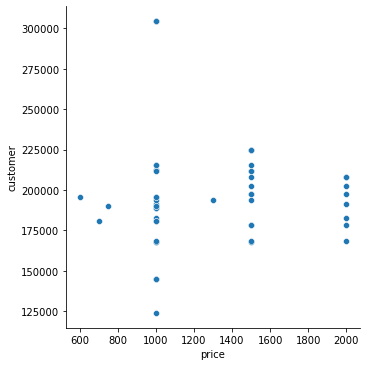

In [53]:
Visualize_market('무(1kg)','1개','목3동시장')